In [1]:
!python --version

Python 3.11.13


# 1. Load Dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd

# Load dataset dari Google Drive
file_path = '/content/drive/MyDrive/Colab Notebooks/AIS Dataset on Cloud DDoS Attacks.csv'
df = pd.read_csv(file_path)

Mounted at /content/drive


# 2. EDA (Exploratory Data Analysis)

In [3]:
# Cek dimensi dataset
print("Dimensi dataset:", df.shape)

Dimensi dataset: (52318, 80)


In [4]:
# Tampilkan 5 baris pertama
df.head()

,Source Port,Destination Port,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,...,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Inbound,label
0,52380,443,6,1,2,0,0,0,0,0,...,0.000000e+00,0.000000e+00,0,0,0.000000e+00,0.000000e+00,0,0,0,BENIGN
1,443,52380,6,2,3,0,62,0,31,0,...,0.000000e+00,0.000000e+00,0,0,0.000000e+00,0.000000e+00,0,0,1,BENIGN
2,443,52380,6,218,1,2,0,0,0,0,...,0.000000e+00,0.000000e+00,0,0,0.000000e+00,0.000000e+00,0,0,1,BENIGN
3,0,0,0,115366430,52,0,0,0,0,0,...,6.666667e+00,1.073087e+00,8,4,9.613862e+06,2.884856e+05,9988327,9110910,0,BENIGN
4,68,67,17,109157387,16,0,4800,0,300,300,...,5.929966e+06,3.774939e+06,10054849,2647210,1.015194e+07,2.795046e+06,14600796,6304546,0,BENIGN


Distribusi label:
label
DDOS      26892
BENIGN    25426
Name: count, dtype: int64


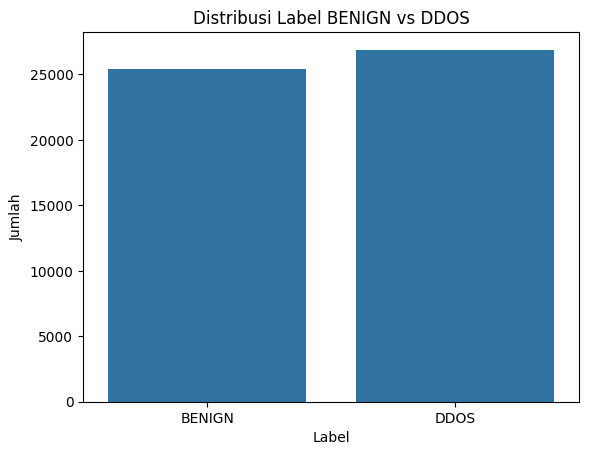

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

# Cek nilai unik label
print("Distribusi label:")
print(df['label'].value_counts())

# Visualisasi distribusi label
sns.countplot(data=df, x='label')
plt.title("Distribusi Label BENIGN vs DDOS")
plt.xlabel("Label")
plt.ylabel("Jumlah")
plt.xticks(rotation=0)
plt.show()

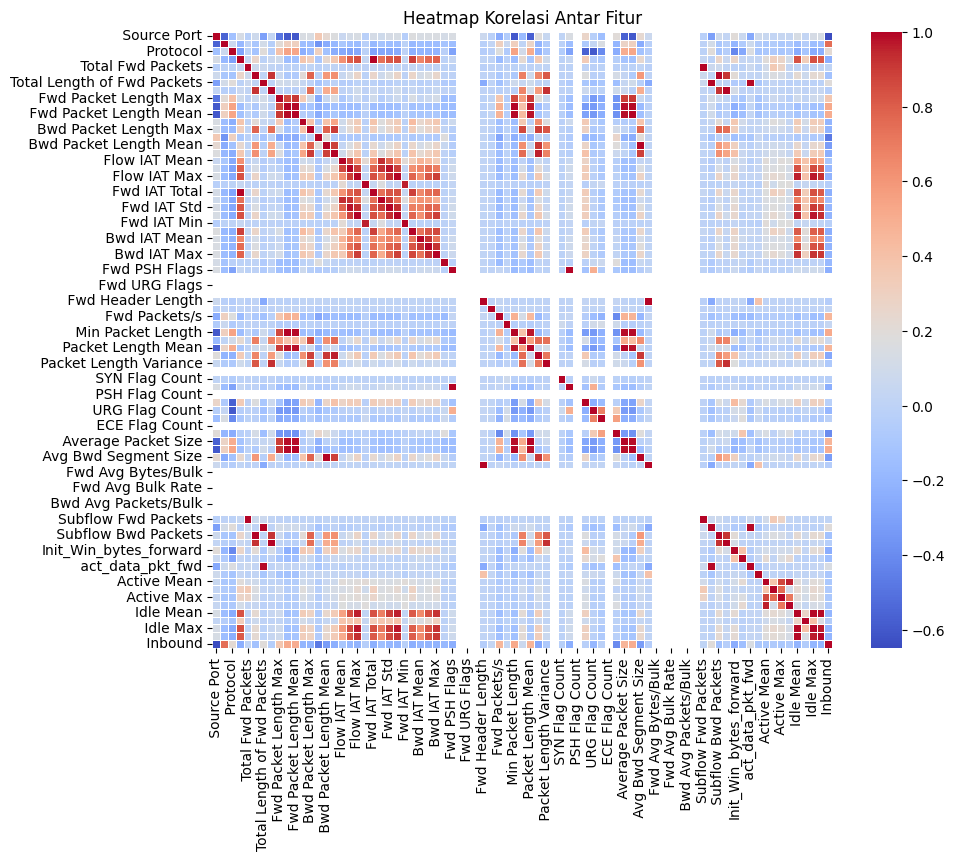

In [6]:
# Hitung korelasi antar fitur
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(numeric_only=True), cmap='coolwarm', annot=False, linewidths=0.5)
plt.title("Heatmap Korelasi Antar Fitur")
plt.show()

# 3. Pre-processing Data

In [7]:
# Cek nilai unik label
print("Nilai unik pada kolom 'label':", df['label'].unique())

# Encode label: BENIGN = 0, DDOS = 1
df['label'] = df['label'].map({'BENIGN': 0, 'DDOS': 1})

# Pastikan tidak ada nilai NaN setelah encoding
print("Cek nilai NaN setelah encoding:", df['label'].isnull().sum())

# Pisahkan fitur dan label
X = df.drop(columns=['label'])  # Semua kolom kecuali label
y = df['label']

# Normalisasi fitur
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Ubah kembali ke DataFrame untuk memudahkan analisis ke depan
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

print("Normalisasi selesai. Bentuk data setelah normalisasi:", X_scaled_df.shape)

Nilai unik pada kolom 'label': ['BENIGN' 'DDOS']
Cek nilai NaN setelah encoding: 0
Normalisasi selesai. Bentuk data setelah normalisasi: (52318, 79)


# Train Baseline Random Forest + Evaluasi

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score
import numpy as np

# Inisialisasi model
rf = RandomForestClassifier(random_state=42)

# K-Fold Cross Validation
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Simpan hasil evaluasi
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
kappa_scores = []

for fold, (train_index, test_index) in enumerate(skf.split(X_scaled_df, y), 1):
    X_train, X_test = X_scaled_df.iloc[train_index], X_scaled_df.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)

    # Evaluasi metrik
    accuracy_scores.append(accuracy_score(y_test, y_pred))
    precision_scores.append(precision_score(y_test, y_pred))
    recall_scores.append(recall_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))
    kappa_scores.append(cohen_kappa_score(y_test, y_pred))

    print(f"Fold {fold} selesai")

# Tampilkan rata-rata hasil
print("\n=== Baseline Random Forest Evaluation (10-Fold CV) ===")
print(f"Accuracy: {np.mean(accuracy_scores):.4f}")
print(f"Precision: {np.mean(precision_scores):.4f}")
print(f"Recall: {np.mean(recall_scores):.4f}")
print(f"F1-Score: {np.mean(f1_scores):.4f}")
print(f"Kappa: {np.mean(kappa_scores):.4f}")

Fold 1 selesai
Fold 2 selesai
Fold 3 selesai
Fold 4 selesai
Fold 5 selesai
Fold 6 selesai
Fold 7 selesai
Fold 8 selesai
Fold 9 selesai
Fold 10 selesai

=== Baseline Random Forest Evaluation (10-Fold CV) ===
Accuracy: 0.9998
Precision: 0.9999
Recall: 0.9997
F1-Score: 0.9998
Kappa: 0.9996


/tmp/ipython-input-9-944350475.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_melted, x='Metrik', y='Skor', palette='Set3')


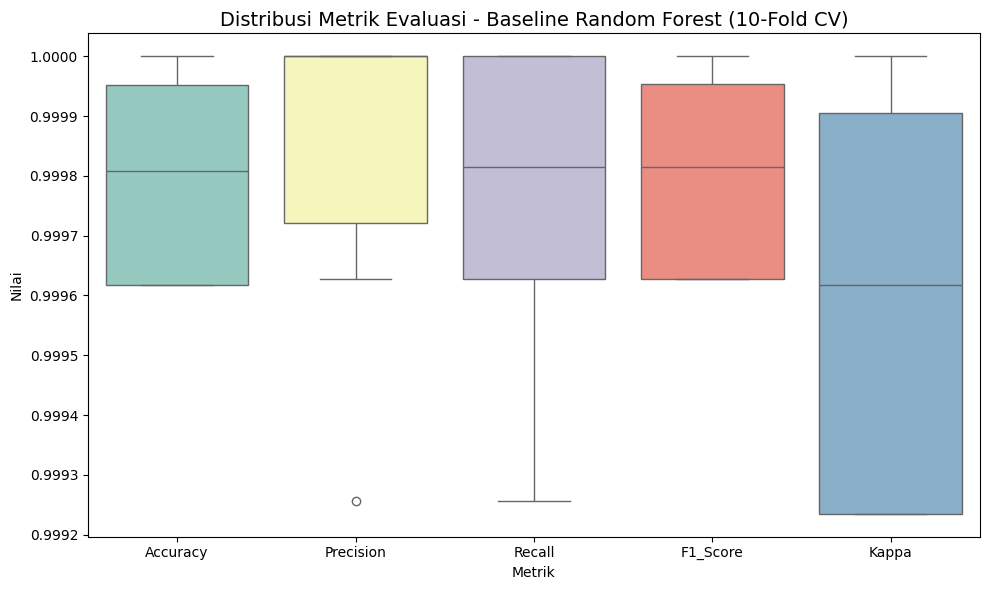

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Buat DataFrame dari skor-skor yang telah dihitung
df_baseline = pd.DataFrame({
    'Accuracy': accuracy_scores,
    'Precision': precision_scores,
    'Recall': recall_scores,
    'F1_Score': f1_scores,
    'Kappa': kappa_scores
})

# Ubah ke bentuk long untuk plotting (melt)
df_melted = df_baseline.melt(var_name='Metrik', value_name='Skor')

# Plot boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_melted, x='Metrik', y='Skor', palette='Set3')

# Tambahkan judul dan label
plt.title('Distribusi Metrik Evaluasi - Baseline Random Forest (10-Fold CV)', fontsize=14)
plt.ylabel('Nilai')
plt.xlabel('Metrik')

plt.tight_layout()
plt.show()

Simpan Hasil Evaluasi Baseline RF ke CSV

In [10]:
import pandas as pd

# Buat DataFrame dari hasil evaluasi
baseline_results = pd.DataFrame({
    'Fold': list(range(1, 11)),
    'Accuracy': accuracy_scores,
    'Precision': precision_scores,
    'Recall': recall_scores,
    'F1_Score': f1_scores,
    'Kappa': kappa_scores
})

# Simpan ke Google Drive
output_path = '/content/drive/MyDrive/Colab Notebooks/baseline_rf_results.csv'
baseline_results.to_csv(output_path, index=False)

print(f"Hasil evaluasi baseline berhasil disimpan ke: {output_path}")

Hasil evaluasi baseline berhasil disimpan ke: /content/drive/MyDrive/Colab Notebooks/baseline_rf_results.csv


# Train Seleksi Fitur RF

# a. Correlation-based Feature Selection (CFS Approximation)

In [11]:
# Gabungkan kembali X dan y untuk korelasi
df_corr = X_scaled_df.copy()
df_corr['label'] = y

# Hitung korelasi terhadap label
correlations = df_corr.corr()['label'].drop('label')

# Tampilkan korelasi
print("Korelasi fitur terhadap label:")
print(correlations.sort_values(ascending=False))

# Threshold korelasi (misalnya 0.1)
threshold = 0.1
selected_features_cfs = correlations[abs(correlations) > threshold].index.tolist()

print(f"\nFitur terpilih (|corr| > {threshold}): {len(selected_features_cfs)} fitur")
print(selected_features_cfs)

# Buat data baru dengan fitur terpilih
X_cfs = X_scaled_df[selected_features_cfs]

Korelasi fitur terhadap label:
 Inbound                   0.828626
 Min Packet Length         0.610927
 Fwd Packet Length Min     0.609752
 Avg Fwd Segment Size      0.602293
 Fwd Packet Length Mean    0.602293
                             ...   
 Fwd Avg Packets/Bulk           NaN
 Fwd Avg Bulk Rate              NaN
 Bwd Avg Bytes/Bulk             NaN
 Bwd Avg Packets/Bulk           NaN
Bwd Avg Bulk Rate               NaN
Name: label, Length: 79, dtype: float64

Fitur terpilih (|corr| > 0.1): 48 fitur
[' Source Port', ' Destination Port', ' Protocol', ' Flow Duration', ' Total Backward Packets', 'Total Length of Fwd Packets', ' Fwd Packet Length Max', ' Fwd Packet Length Min', ' Fwd Packet Length Mean', ' Fwd Packet Length Std', 'Bwd Packet Length Max', ' Bwd Packet Length Min', ' Bwd Packet Length Mean', ' Bwd Packet Length Std', ' Flow IAT Std', ' Flow IAT Max', 'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std', ' Fwd IAT Max', 'Bwd IAT Total', ' Bwd IAT Mean', ' Bwd IAT Std', ' Bwd 

In [12]:
# Inisialisasi ulang model dan metrik
rf_cfs = RandomForestClassifier(random_state=42)

# Reset metrik
acc_cfs, prec_cfs, rec_cfs, f1_cfs, kappa_cfs = [], [], [], [], []

for fold, (train_idx, test_idx) in enumerate(skf.split(X_cfs, y), 1):
    X_train, X_test = X_cfs.iloc[train_idx], X_cfs.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    rf_cfs.fit(X_train, y_train)
    y_pred = rf_cfs.predict(X_test)

    acc_cfs.append(accuracy_score(y_test, y_pred))
    prec_cfs.append(precision_score(y_test, y_pred))
    rec_cfs.append(recall_score(y_test, y_pred))
    f1_cfs.append(f1_score(y_test, y_pred))
    kappa_cfs.append(cohen_kappa_score(y_test, y_pred))

    print(f"Fold {fold} selesai (CFS)")

# Rata-rata hasil
print("\n=== Random Forest + CFS Evaluation (10-Fold CV) ===")
print(f"Accuracy: {np.mean(acc_cfs):.4f}")
print(f"Precision: {np.mean(prec_cfs):.4f}")
print(f"Recall: {np.mean(rec_cfs):.4f}")
print(f"F1-Score: {np.mean(f1_cfs):.4f}")
print(f"Kappa: {np.mean(kappa_cfs):.4f}")

Fold 1 selesai (CFS)
Fold 2 selesai (CFS)
Fold 3 selesai (CFS)
Fold 4 selesai (CFS)
Fold 5 selesai (CFS)
Fold 6 selesai (CFS)
Fold 7 selesai (CFS)
Fold 8 selesai (CFS)
Fold 9 selesai (CFS)
Fold 10 selesai (CFS)

=== Random Forest + CFS Evaluation (10-Fold CV) ===
Accuracy: 0.9998
Precision: 0.9999
Recall: 0.9997
F1-Score: 0.9998
Kappa: 0.9997


/tmp/ipython-input-13-3702684837.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_rf_cfs_melted, x='Metrik', y='Skor', palette='Set2')


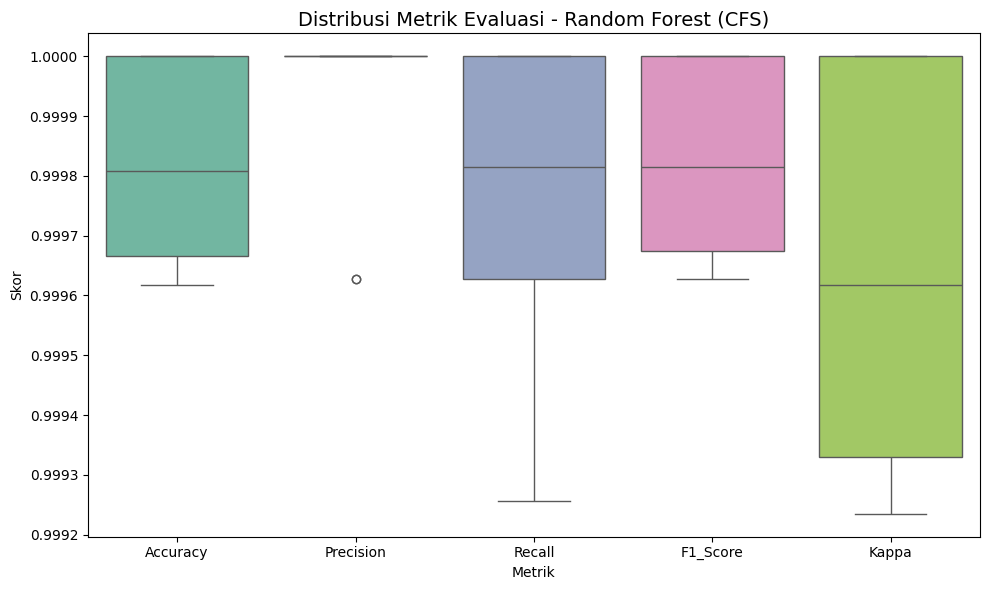

In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Buat DataFrame dari hasil evaluasi
df_rf_cfs = pd.DataFrame({
    'Accuracy': acc_cfs,
    'Precision': prec_cfs,
    'Recall': rec_cfs,
    'F1_Score': f1_cfs,
    'Kappa': kappa_cfs
})

# Ubah ke format long (melt) agar bisa digunakan oleh seaborn
df_rf_cfs_melted = df_rf_cfs.melt(var_name='Metrik', value_name='Skor')

# Plot boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_rf_cfs_melted, x='Metrik', y='Skor', palette='Set2')

# Tambahkan judul dan label sumbu
plt.title('Distribusi Metrik Evaluasi - Random Forest (CFS)', fontsize=14)
plt.xlabel('Metrik')
plt.ylabel('Skor')

plt.tight_layout()
plt.show()

Simpan hasil evaluasi RF + CFS ke CSV

In [14]:
rf_cfs_results = pd.DataFrame({
    'Fold': list(range(1, 11)),
    'Accuracy': acc_cfs,
    'Precision': prec_cfs,
    'Recall': rec_cfs,
    'F1_Score': f1_cfs,
    'Kappa': kappa_cfs
})

output_path_cfs = '/content/drive/MyDrive/Colab Notebooks/rf_cfs_results.csv'
rf_cfs_results.to_csv(output_path_cfs, index=False)

print(f"Hasil evaluasi RF + CFS disimpan ke: {output_path_cfs}")


Hasil evaluasi RF + CFS disimpan ke: /content/drive/MyDrive/Colab Notebooks/rf_cfs_results.csv


# b. Rough Set

In [15]:
from sklearn.feature_selection import mutual_info_classif

# Hitung nilai mutual information tiap fitur terhadap label
mi = mutual_info_classif(X_scaled_df, y, discrete_features=False)
mi_series = pd.Series(mi, index=X_scaled_df.columns).sort_values(ascending=False)

# Tentukan threshold atau ambil top-N fitur (misalnya top 20)
top_n = 20
selected_features_rs = mi_series.head(top_n).index.tolist()

print(f"Fitur terpilih dari Rough Set Simplified (top {top_n} MI):")
print(selected_features_rs)

# Dataset dengan fitur hasil Rough Set
X_rs = X_scaled_df[selected_features_rs]

Fitur terpilih dari Rough Set Simplified (top 20 MI):
[' Destination Port', ' Source Port', ' Fwd Packet Length Mean', ' Avg Fwd Segment Size', ' Max Packet Length', ' Average Packet Size', ' Packet Length Mean', ' Fwd Packet Length Max', ' Fwd Packet Length Min', ' Min Packet Length', 'Total Length of Fwd Packets', ' Subflow Fwd Bytes', ' Flow IAT Mean', ' Inbound', ' Flow IAT Max', 'Fwd Packets/s', ' Bwd Packets/s', ' Flow Duration', ' Flow IAT Std', ' Bwd Header Length']


In [16]:
rf_rs = RandomForestClassifier(random_state=42)

# Reset metrik
acc_rs, prec_rs, rec_rs, f1_rs, kappa_rs = [], [], [], [], []

for fold, (train_idx, test_idx) in enumerate(skf.split(X_rs, y), 1):
    X_train, X_test = X_rs.iloc[train_idx], X_rs.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    rf_rs.fit(X_train, y_train)
    y_pred = rf_rs.predict(X_test)

    acc_rs.append(accuracy_score(y_test, y_pred))
    prec_rs.append(precision_score(y_test, y_pred))
    rec_rs.append(recall_score(y_test, y_pred))
    f1_rs.append(f1_score(y_test, y_pred))
    kappa_rs.append(cohen_kappa_score(y_test, y_pred))

    print(f"Fold {fold} selesai")

# Rata-rata hasil
print("\n=== Random Forest + RS Evaluation (10-Fold CV) ===")
print(f"Accuracy: {np.mean(acc_rs):.4f}")
print(f"Precision: {np.mean(prec_rs):.4f}")
print(f"Recall: {np.mean(rec_rs):.4f}")
print(f"F1-Score: {np.mean(f1_rs):.4f}")
print(f"Kappa: {np.mean(kappa_rs):.4f}")

Fold 1 selesai
Fold 2 selesai
Fold 3 selesai
Fold 4 selesai
Fold 5 selesai
Fold 6 selesai
Fold 7 selesai
Fold 8 selesai
Fold 9 selesai
Fold 10 selesai

=== Random Forest + RS Evaluation (10-Fold CV) ===
Accuracy: 0.9999
Precision: 1.0000
Recall: 0.9999
F1-Score: 0.9999
Kappa: 0.9998


/tmp/ipython-input-17-4203139711.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_rf_rs_melted, x='Metrik', y='Skor', palette='Set2')


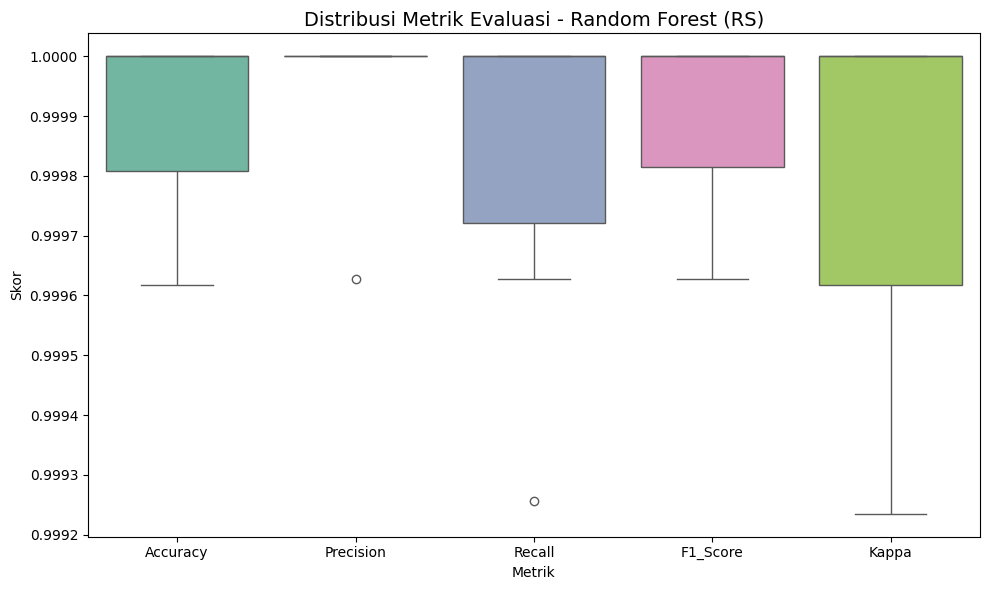

In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Buat DataFrame dari hasil evaluasi
df_rf_rs = pd.DataFrame({
    'Accuracy': acc_rs,
    'Precision': prec_rs,
    'Recall': rec_rs,
    'F1_Score': f1_rs,
    'Kappa': kappa_rs
})

# Ubah ke format long (melt) agar bisa digunakan oleh seaborn
df_rf_rs_melted = df_rf_rs.melt(var_name='Metrik', value_name='Skor')

# Plot boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_rf_rs_melted, x='Metrik', y='Skor', palette='Set2')

# Tambahkan judul dan label sumbu
plt.title('Distribusi Metrik Evaluasi - Random Forest (RS)', fontsize=14)
plt.xlabel('Metrik')
plt.ylabel('Skor')

plt.tight_layout()
plt.show()

Simpan hasil evaluasi RF + RS ke CSV

In [18]:
rf_rs_results = pd.DataFrame({
    'Fold': list(range(1, 11)),
    'Accuracy': acc_rs,
    'Precision': prec_rs,
    'Recall': rec_rs,
    'F1_Score': f1_rs,
    'Kappa': kappa_rs
})

output_path_rs = '/content/drive/MyDrive/Colab Notebooks/rf_rs_results.csv'
rf_rs_results.to_csv(output_path_rs, index=False)

print(f"Hasil evaluasi RF + Rough Set disimpan ke: {output_path_rs}")

Hasil evaluasi RF + Rough Set disimpan ke: /content/drive/MyDrive/Colab Notebooks/rf_rs_results.csv


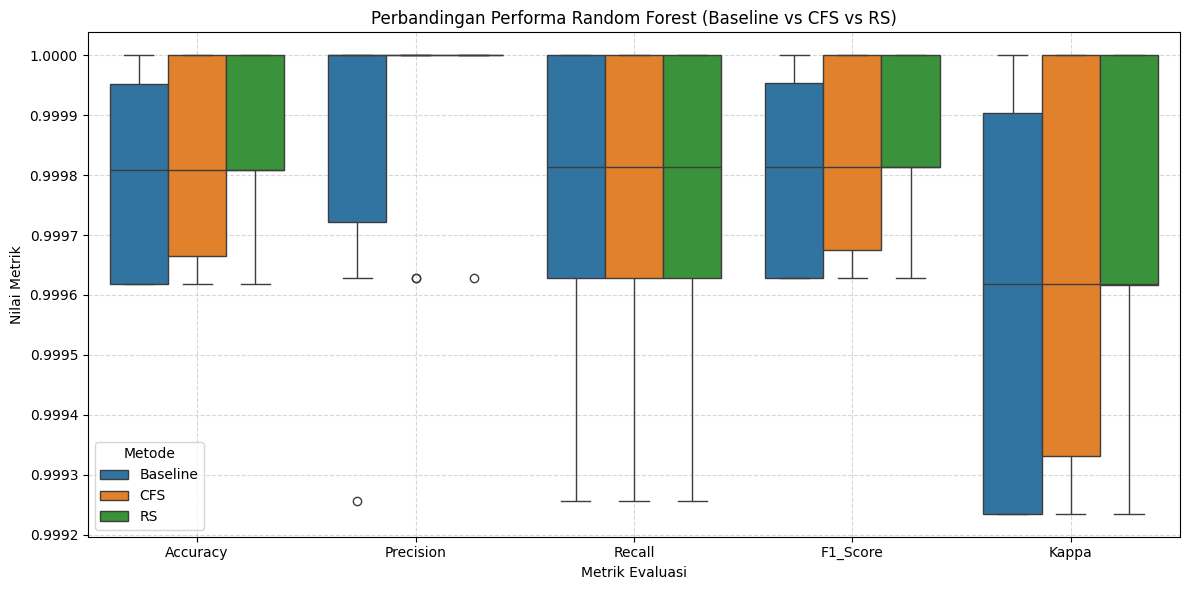

In [22]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load ketiga CSV
baseline = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/RF/baseline_rf_results.csv")
cfs = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/RF/rf_cfs_results.csv")
rs = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/RF/rf_rs_results.csv")

# Tambahkan kolom 'metode' sebagai label
baseline['metode'] = 'Baseline'
cfs['metode'] = 'CFS'
rs['metode'] = 'RS'

# Gabungkan semua menjadi satu DataFrame
df = pd.concat([baseline, cfs, rs], ignore_index=True)

# Ubah dari wide ke long format
df_long = pd.melt(df,
                  id_vars=['Fold', 'metode'],
                  value_vars=['Accuracy', 'Precision', 'Recall', 'F1_Score', 'Kappa'],
                  var_name='metrik',
                  value_name='nilai')

# Buat box plot
plt.figure(figsize=(12, 6))
sns.boxplot(x='metrik', y='nilai', hue='metode', data=df_long)
plt.title('Perbandingan Performa Random Forest (Baseline vs CFS vs RS)')
plt.ylabel('Nilai Metrik')
plt.xlabel('Metrik Evaluasi')
plt.legend(title='Metode')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()